In [147]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle
from urllib.parse import unquote
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GraphNorm
from tqdm import tqdm
import random
from torch_geometric.nn.models import GCN

# Load Data

In [148]:
# Load text data
data = pd.read_csv(f"../../data/full_text_data.csv")

In [149]:
# Load links
links = pd.read_csv("../../data/Wikispeedia/links.tsv", sep="\t", names=["src", "tgt"], skiprows=12)
links["src"] = links["src"].map(lambda x: unquote(x))
links["tgt"] = links["tgt"].map(lambda x: unquote(x))

# Create adjacency matrix
ordered_data_titles = data["title"].tolist()
src_indices = links["src"].map(lambda x: ordered_data_titles.index(x))
tgt_indices = links["tgt"].map(lambda x: ordered_data_titles.index(x))
A = torch.zeros((len(ordered_data_titles), len(ordered_data_titles)))
A[src_indices, tgt_indices] = 1

In [150]:
# Load coherence graph
with open("../../data/coherence_graph.pkl", 'rb') as handle:
    coherence_graph = pickle.load(handle)

# Combine coherence graph with base links
edge_features = A * coherence_graph

/var/folders/kt/8729r9s16_15cc905qks8zl40000gn/T/ipykernel_10523/3991216429.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  edge_features = A * coherence_graph


In [151]:
# Load node embeddings
with open("../../data/gpt4_embeddings.pkl", 'rb') as handle:
    obj = pickle.load(handle)
    node_static_embeddings = obj["embeddings"]
    del obj
node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)
node_static_embeddings

/var/folders/kt/8729r9s16_15cc905qks8zl40000gn/T/ipykernel_10523/2880839170.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)


tensor([[ 0.0038,  0.0096,  0.0519,  ..., -0.0275,  0.0512, -0.0136],
        [-0.0361,  0.0142,  0.0874,  ..., -0.0140, -0.0216,  0.0194],
        [ 0.0341,  0.0069,  0.0078,  ...,  0.0070,  0.0373, -0.0153],
        ...,
        [-0.0165,  0.0102,  0.0054,  ...,  0.0072,  0.0459, -0.0378],
        [-0.0212,  0.0331,  0.0266,  ..., -0.0187,  0.0237, -0.0141],
        [ 0.0375,  0.0523,  0.0282,  ...,  0.0183, -0.0107, -0.0030]])

In [152]:
# Load user-extracted paths
paths_data = pd.read_csv(f"../../data/paths_no_back_links.tsv", sep="\t")
paths_data = paths_data[~(paths_data["rating"].isna())]

# Filter paths with at least four distinct pages
# paths_data = paths_data[paths_data["path"].apply(lambda x: len(set(x.split(";"))) >= 4)]

# Map titles to indices
title_to_index = {unquote(title): idx for idx, title in enumerate(data['title'])}
paths = paths_data['path'].apply(lambda path: [title_to_index[unquote(title)] for title in path.split(';')]).tolist()
ratings = (paths_data['rating'] - 1).tolist()  # 0-indexed ratings

# # Binary ratings
ratings = [1 if r > 1 else 0 for r in ratings]

In [153]:
class PathDataset(Dataset):
    def __init__(self, paths, ratings, node_embeddings, edge_features):
        self.paths = paths
        self.ratings = ratings
        self.node_embeddings = node_embeddings
        self.edge_features = edge_features

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        rating = self.ratings[idx]
        nodes, edge_index, edge_weight = self.get_subgraph_edges(path)

        x = self.node_embeddings[nodes]

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_weight=edge_weight,
            y=torch.tensor([rating], dtype=torch.long)
        )
        return data

    def get_subgraph_edges(self, path):
        nodes = list(set(path))
        node_to_idx = {node: idx for idx, node in enumerate(nodes)}
        edges = []
        edge_weights = []
        for i in nodes:
            for j in nodes:
                weight = self.edge_features[i, j]
                if weight > 0:
                    edges.append([node_to_idx[i], node_to_idx[j]])
                    edge_weights.append(weight)
        if edges:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weights, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.tensor([], dtype=torch.float)
        return nodes, edge_index, edge_weight

# Create dataset
dataset = PathDataset(paths, ratings, node_static_embeddings, edge_features)

# Split dataset
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.1
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/Users/jiahaoxu/Github/wikispeedia-gnn/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [154]:
# Counts occurrences of each class
class_counts = torch.bincount(
    torch.tensor(ratings)[train_dataset.indices].to(torch.int64)
)

# Calculate weights as the inverse of class frequencies
class_weights = 1.0 / class_counts.float()

# Normalize the weights so that they sum to the number of classes
class_weights = class_weights / class_weights.sum() * len(class_counts)

class_weights

tensor([0.7851, 1.2149])

# GCN model

In [155]:
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes, dropout=0.2):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.norm1 = GraphNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.norm2 = GraphNorm(out_channels)
        self.classifier = torch.nn.Linear(out_channels, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x)

        x = global_mean_pool(x, batch=data.batch)

        x = self.classifier(x)
        return x  # Return raw logits

# Training

In [156]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)

model = GCNModel(
    in_channels=node_static_embeddings.shape[1],
    hidden_channels=64,
    out_channels=32,
    num_classes=2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

best_val_acc = 0
for epoch in range(1, 6):
    loss = train()
    val_acc = evaluate(val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save the best model
        torch.save(model.state_dict(), '.best_binary_model.pth')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 4038/4038 [00:13<00:00, 296.41it/s]


Epoch: 001, Loss: 0.6682, Val Acc: 0.6098


100%|██████████| 4038/4038 [00:13<00:00, 296.00it/s]


Epoch: 002, Loss: 0.6666, Val Acc: 0.6098


100%|██████████| 4038/4038 [00:13<00:00, 299.51it/s]


Epoch: 003, Loss: 0.6677, Val Acc: 0.6098


100%|██████████| 4038/4038 [00:13<00:00, 296.58it/s]


Epoch: 004, Loss: 0.6674, Val Acc: 0.6098


100%|██████████| 4038/4038 [00:13<00:00, 297.20it/s]


Epoch: 005, Loss: 0.6693, Val Acc: 0.6098


In [157]:
# Load the best model
model.load_state_dict(torch.load('.best_binary_model.pth'))

test_acc = evaluate(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

/var/folders/kt/8729r9s16_15cc905qks8zl40000gn/T/ipykernel_10523/2583839261.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('.best_binar

Test Accuracy: 0.6138


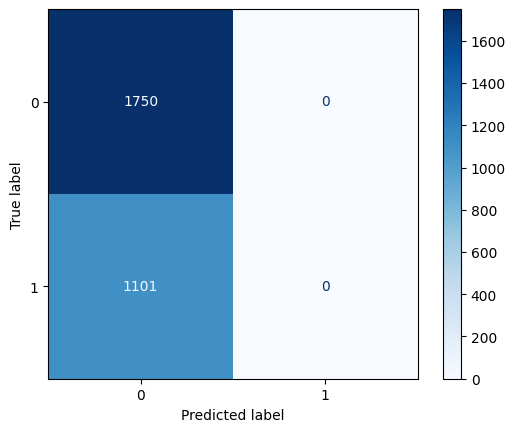

In [158]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def conf_matrix(model, dataset_loader):
    # Pass the testing loader through the model
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in dataset_loader:
            batch = batch.to(device)  # Move batch to the same device as the model
            logits = model(batch)  # Pass the entire batch to the model
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Assuming your trained model is named 'model' and your DataLoader is 'test_loader'
conf_matrix(model, test_loader)